In [105]:
import csv
import os
from pprint import pprint
from SPARQLWrapper import SPARQLWrapper,TURTLE,JSON
from pandas_ml import ConfusionMatrix
import pandas as pd
from sklearn import metrics

In [89]:
POIS_PATH = os.path.normpath('doremus_dbpedia_artists.csv')

with open(POIS_PATH, 'r') as input_fp:

    reader = csv.reader(input_fp, )
    # skip header
    reader.next()
    matches = []
    for row in reader:
        match = dict()
        match['doremus_uri'] = row[0]
        match['dbpedia_uri'] = row[1]
        match['score'] = row[2]
        matches.append(match)

In [90]:
len(matches)

16585

In [91]:
offset = 0
finished = False
true_matches = []

while finished is False:
    sparql = SPARQLWrapper("http://data.doremus.org/sparql")
    sparql.setReturnFormat(JSON)
    sparql.setQuery(
    """
    SELECT DISTINCT ?artist ?dbpedia
    WHERE {
      ?artist a ecrm:E21_Person ;
      owl:sameAs ?dbpedia .
      FILTER (strStarts(str(?dbpedia), 'http://dbpedia.org/resource/'))
    } limit 1000
    offset %d
    """ % offset)

    results = sparql.query().convert()
    if len(results['results']['bindings']) > 0:
        for result in results['results']['bindings']:
            match = dict()
            match['doremus_uri'] = result['artist']['value']
            match['dbpedia_uri'] = result['dbpedia']['value']
            true_matches.append(match)          
        offset += 1000
    else:
        finished = True

In [338]:
def stats(matches,true_matches,threshold=0):
    predicted = pd.DataFrame(matches)
    predicted = predicted[predicted['score'].astype(float) > threshold]

    true = pd.DataFrame(true_matches)
    join = true.merge(predicted, on='doremus_uri')
    predicted_disjoint = predicted[~predicted['doremus_uri'].isin(true['doremus_uri'])].sort_values(by='score')
    types = join.apply(lambda x: pd.lib.infer_dtype(x.values))
    for col in types[types=='unicode'].index:
        join[col] = join[col].apply(lambda x: x.encode('utf-8').strip())
    true_label = list(join['dbpedia_uri_x'])
    predict_label = list(join['dbpedia_uri_y'])
    # calculate accuracy
    accuracy = metrics.accuracy_score(true_label, predict_label)
#    print('accuracy: %.4f' % metrics.accuracy_score(true_label, predict_label))
    precision = metrics.precision_score(true_label, predict_label,average='macro')
#    print('precision: %.4f' % metrics.precision_score(true_label, predict_label,average='macro'))
    recall = metrics.recall_score(true_label, predict_label,average='macro')
#    print('recall: %.4f' % metrics.recall_score(true_label, predict_label,average='macro'))
    f1 = metrics.f1_score(true_label, predict_label,average='macro')
#    print('f1: %.4f' % metrics.f1_score(true_label, predict_label,average='macro'))

    equal = join[join.apply(lambda x: x['dbpedia_uri_x'] == x['dbpedia_uri_y'], axis=1)]
    unequal = join[join.apply(lambda x: x['dbpedia_uri_x'] != x['dbpedia_uri_y'], axis=1)]
    return (accuracy,precision,recall,f1,len(join),len(predicted),len(true),len(equal),len(unequal),len(predicted_disjoint))

In [339]:
import numpy as np
stat_list = []
for threshold in np.arange(0,4.4,0.1):
    values = list(stats(matches,true_matches,threshold))
    values.append(threshold)
    stat_list.append(values)
stat_list = np.array(stat_list)

In [ ]:
#accuracy,precision,recall,f1,intersection,predicted,true,threshold

In [340]:
import matplotlib.pyplot as plt

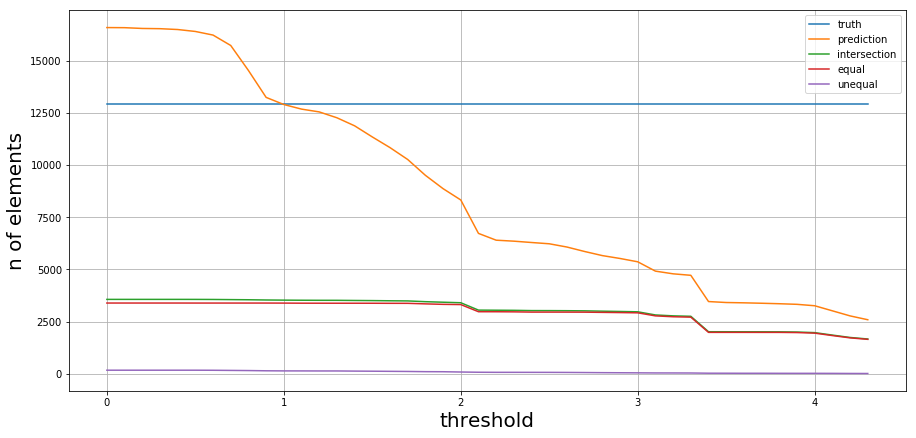

In [358]:

plt.figure(figsize=(15,7))

plt.plot(stat_list[:,-1],stat_list[:,6])
plt.plot(stat_list[:,-1],stat_list[:,5])
plt.plot(stat_list[:,-1],stat_list[:,4])
plt.plot(stat_list[:,-1],stat_list[:,7])
plt.plot(stat_list[:,-1],stat_list[:,8])

plt.grid()
plt.xlabel('threshold', fontsize=20)
plt.ylabel('n of elements', fontsize=20)
plt.legend(['truth','prediction', 'intersection','equal','unequal'])
plt.show()

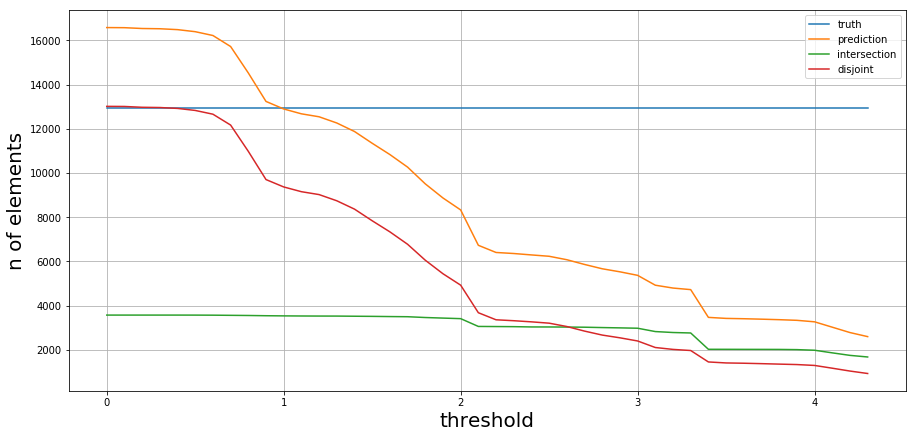

In [359]:

plt.figure(figsize=(15,7))

plt.plot(stat_list[:,-1],stat_list[:,6])
plt.plot(stat_list[:,-1],stat_list[:,5])
plt.plot(stat_list[:,-1],stat_list[:,4])
plt.plot(stat_list[:,-1],stat_list[:,9])

plt.grid()
plt.xlabel('threshold', fontsize=20)
plt.ylabel('n of elements', fontsize=20)
plt.legend(['truth','prediction', 'intersection','disjoint'])
plt.show()

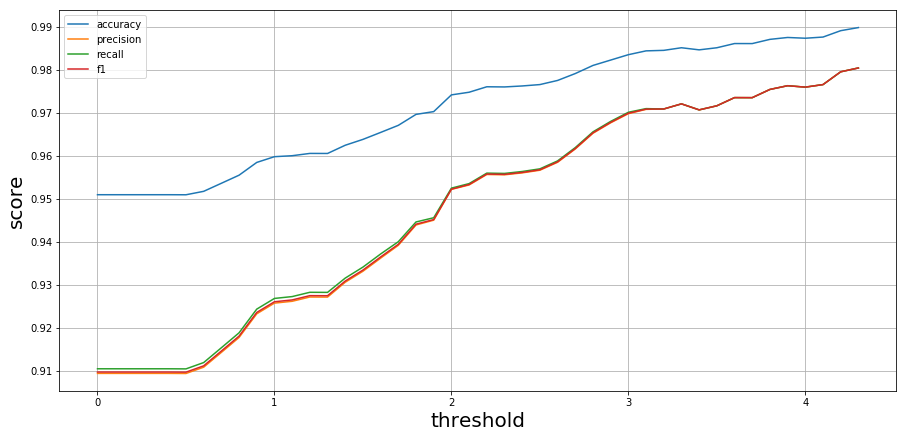

In [305]:
plt.figure(figsize=(15,7))
plt.plot(stat_list[:,-1],stat_list[:,0])
plt.plot(stat_list[:,-1],stat_list[:,1])
plt.plot(stat_list[:,-1],stat_list[:,2])
plt.plot(stat_list[:,-1],stat_list[:,3])
plt.grid()
plt.xlabel('threshold', fontsize=20)
plt.ylabel('score', fontsize=20)
plt.legend(['accuracy', 'precision','recall','f1'])
plt.show()

In [360]:
def get_slice_different(matches,true_matches,min_,max_):
    predicted = pd.DataFrame(matches)
    predicted = predicted[predicted['score'].astype(float) > min_]
    predicted = predicted[predicted['score'].astype(float) <= max_]
    true = pd.DataFrame(true_matches)
    join = true.merge(predicted, on='doremus_uri')
    for col in types[types=='unicode'].index:
        join[col] = join[col].apply(lambda x: x.encode('utf-8').strip())
    join = join[join.apply(lambda x: x['dbpedia_uri_x'] != x['dbpedia_uri_y'], axis=1)]
    print(len(join))

    a= join[['dbpedia_uri_y','dbpedia_uri_x','doremus_uri']].values.tolist()
    for uri in a:
        pprint(uri)
        
def get_slice_equal(matches,true_matches,min_,max_):
    predicted = pd.DataFrame(matches)
    predicted = predicted[predicted['score'].astype(float) > min_]
    predicted = predicted[predicted['score'].astype(float) <= max_]
    true = pd.DataFrame(true_matches)
    join = true.merge(predicted, on='doremus_uri')
    for col in types[types=='unicode'].index:
        join[col] = join[col].apply(lambda x: x.encode('utf-8').strip())
    join = join[join.apply(lambda x: x['dbpedia_uri_x'] == x['dbpedia_uri_y'], axis=1)]
    print(len(join))

    a= join[['dbpedia_uri_y','dbpedia_uri_x','doremus_uri']].values.tolist()
    for uri in a:
        pprint(uri)
        
def get_slice_disjoint(matches,true_matches,min_,max_):
    predicted = pd.DataFrame(matches)
    predicted = predicted[predicted['score'].astype(float) > min_]
    predicted = predicted[predicted['score'].astype(float) <= max_]
    true = pd.DataFrame(true_matches)
    join = true.merge(predicted, on='doremus_uri')
    for col in types[types=='unicode'].index:
        join[col] = join[col].apply(lambda x: x.encode('utf-8').strip())
    join = join[join.apply(lambda x: x['dbpedia_uri_x'] != x['dbpedia_uri_y'], axis=1)]
    print(len(join))

    a= join[['dbpedia_uri_y','dbpedia_uri_x','doremus_uri']].values.tolist()
    for uri in a:
        pprint(uri)

In [308]:
get_slice_different(matches,true_matches,4.0,4.5)

25
['http://dbpedia.org/resource/Lars-Erik_Larsson',
 'http://dbpedia.org/resource/Lars',
 'http://data.doremus.org/artist/9003abb1-f722-3891-a40b-e5f8fad9ca92']
['http://dbpedia.org/resource/\xc3\x89tienne-Joseph_Floquet',
 'http://dbpedia.org/resource/\xc3\x89tienne',
 'http://data.doremus.org/artist/7c4fd9ed-7a5d-39c7-ab4a-d55dede2fe4c']
['http://dbpedia.org/resource/Peter_Cornelius',
 'http://dbpedia.org/resource/Peter_Cornelius_(opera_singer)',
 'http://data.doremus.org/artist/feedb49e-60a1-3d09-9c85-8cac5cadd123']
['http://dbpedia.org/resource/Paul_I,_Prince_Esterh\xc3\xa1zy',
 'http://dbpedia.org/resource/Paul_I',
 'http://data.doremus.org/artist/14494309-66c8-3f85-99ce-c68e3d2d5f0a']
['http://dbpedia.org/resource/Pierre-Octave_Ferroud',
 'http://dbpedia.org/resource/Pierre',
 'http://data.doremus.org/artist/1cbec6fc-d42b-30b5-bdc6-974f58448ba2']
['http://dbpedia.org/resource/Samuel_Coleridge-Taylor',
 'http://dbpedia.org/resource/Samuel_Taylor_Coleridge',
 'http://data.doremus.

In [309]:
get_slice_equal(matches,true_matches,4.0,4.5)

1950
['http://dbpedia.org/resource/Johann_Sebastian_Bach',
 'http://dbpedia.org/resource/Johann_Sebastian_Bach',
 'http://data.doremus.org/artist/269cec9d-5025-3a8a-b2ef-4f7acb088f2b']
['http://dbpedia.org/resource/Gabriel_Faur\xc3\xa9',
 'http://dbpedia.org/resource/Gabriel_Faur\xc3\xa9',
 'http://data.doremus.org/artist/6447cde9-fbd7-3da3-a1bf-ff1176456cd7']
['http://dbpedia.org/resource/Georges_Migot',
 'http://dbpedia.org/resource/Georges_Migot',
 'http://data.doremus.org/artist/7e730c80-72af-3453-80ef-d5f0df768238']
['http://dbpedia.org/resource/Maria_Malibran',
 'http://dbpedia.org/resource/Maria_Malibran',
 'http://data.doremus.org/artist/8763fe67-f0fe-36b0-8a40-fafd99844a28']
['http://dbpedia.org/resource/Hugo_Distler',
 'http://dbpedia.org/resource/Hugo_Distler',
 'http://data.doremus.org/artist/24957689-655a-3be5-a409-38b19e125493']
['http://dbpedia.org/resource/Wilhelm_Berger',
 'http://dbpedia.org/resource/Wilhelm_Berger',
 'http://data.doremus.org/artist/906af9bb-88e1-3e68

In [ ]:
matches true_matches

In [332]:
predicted = pd.DataFrame(matches)
predicted = predicted[predicted['score'].astype(float) > 4.0]
predicted = predicted[predicted['score'].astype(float) <= 4.5]
true = pd.DataFrame(true_matches)

predicted = predicted[~predicted['doremus_uri'].isin(true['doremus_uri'])].sort_values(by='score').values.tolist()
print(len(predicted))
for uri in predicted:
        pprint(uri)

1287
['http://dbpedia.org/resource/Otakar_\xc5\xa0ev\xc4\x8d\xc3\xadk',
 'http://data.doremus.org/artist/2a6efee9-8d7c-33a1-af91-ad4f8fc8ff12',
 '4.003225806451613']
['http://dbpedia.org/resource/Corona_Schr\xc3\xb6ter',
 'http://data.doremus.org/artist/3b0141e8-02c5-3831-b4c7-6c269c9fbb70',
 '4.003773584905661']
['http://dbpedia.org/resource/Alexander_Spendiaryan',
 'http://data.doremus.org/artist/70fd0f13-c35e-313b-82be-4ab86dc56ace',
 '4.003773584905661']
['http://dbpedia.org/resource/Robert_Talbot_(conductor)',
 'http://data.doremus.org/artist/1d624e4d-e792-3d8f-9868-2dfe3108d17d',
 '4.004651162790697']
['http://dbpedia.org/resource/Ella_Adayevskaya',
 'http://data.doremus.org/artist/322eab1b-94c7-3029-b22a-b84ce50b7d42',
 '4.004651162790697']
['http://dbpedia.org/resource/Henri_Cohen_(composer)',
 'http://data.doremus.org/artist/94035adc-d978-394a-af4f-cd7c13d38bd3',
 '4.006060606060606']
['http://dbpedia.org/resource/\xc3\x89tienne_M\xc3\xa9hul',
 'http://data.doremus.org/artist/

# wikidata

In [387]:
POIS_PATH = os.path.normpath('doremus_wikidata_artists.csv')

with open(POIS_PATH, 'r') as input_fp:

    reader = csv.reader(input_fp, )
    # skip header
    reader.next()
    matches = []
    for row in reader:
        match = dict()
        match['doremus_uri'] = row[0]
        match['wikidata_uri'] = row[1]
        match['score'] = row[5]
        matches.append(match)

In [388]:
len(matches)

2149

In [366]:
offset = 0
finished = False
true_matches = []

while finished is False:
    sparql = SPARQLWrapper("http://data.doremus.org/sparql")
    sparql.setReturnFormat(JSON)
    sparql.setQuery(
    """
    SELECT DISTINCT ?artist ?wikidata
    WHERE {
      ?artist a ecrm:E21_Person ;
      owl:sameAs ?wikidata .
      FILTER (strStarts(str(?wikidata), 'http://www.wikidata.org/entity/'))
    } limit 1000
    offset %d
    """ % offset)

    results = sparql.query().convert()
    if len(results['results']['bindings']) > 0:
        for result in results['results']['bindings']:
            match = dict()
            match['doremus_uri'] = result['artist']['value']
            match['wikidata_uri'] = result['wikidata']['value']
            true_matches.append(match)          
        offset += 1000
    else:
        finished = True

In [375]:
len(true_matches)

14631

In [ ]:
def stats(matches,true_matches,threshold=0):
    predicted = pd.DataFrame(matches)
    predicted = predicted[predicted['score'].astype(float) > threshold]

    true = pd.DataFrame(true_matches)
    join = true.merge(predicted, on='doremus_uri')
    predicted_disjoint = predicted[~predicted['doremus_uri'].isin(true['doremus_uri'])].sort_values(by='score')
    types = join.apply(lambda x: pd.lib.infer_dtype(x.values))
    for col in types[types=='unicode'].index:
        join[col] = join[col].apply(lambda x: x.encode('utf-8').strip())
    true_label = list(join['dbpedia_uri_x'])
    predict_label = list(join['dbpedia_uri_y'])
    # calculate accuracy
    accuracy = metrics.accuracy_score(true_label, predict_label)
#    print('accuracy: %.4f' % metrics.accuracy_score(true_label, predict_label))
    precision = metrics.precision_score(true_label, predict_label,average='macro')
#    print('precision: %.4f' % metrics.precision_score(true_label, predict_label,average='macro'))
    recall = metrics.recall_score(true_label, predict_label,average='macro')
#    print('recall: %.4f' % metrics.recall_score(true_label, predict_label,average='macro'))
    f1 = metrics.f1_score(true_label, predict_label,average='macro')
#    print('f1: %.4f' % metrics.f1_score(true_label, predict_label,average='macro'))

    equal = join[join.apply(lambda x: x['dbpedia_uri_x'] == x['dbpedia_uri_y'], axis=1)]
    unequal = join[join.apply(lambda x: x['dbpedia_uri_x'] != x['dbpedia_uri_y'], axis=1)]
    return (accuracy,precision,recall,f1,len(join),len(predicted),len(true),len(equal),len(unequal),len(predicted_disjoint))

In [379]:
def stats(matches,true_matches,threshold=0):
    predicted = pd.DataFrame(matches)
    predicted = predicted[predicted['score'].astype(float) > threshold]

    true = pd.DataFrame(true_matches)
    join = true.merge(predicted, on='doremus_uri')
    predicted_disjoint = predicted[~predicted['doremus_uri'].isin(true['doremus_uri'])].sort_values(by='score')
    types = join.apply(lambda x: pd.lib.infer_dtype(x.values))
    
    for col in types[types=='unicode'].index:
        join[col] = join[col].apply(lambda x: x.encode('utf-8').strip())
    true_label = list(join['wikidata_uri_x'])
    predict_label = list(join['wikidata_uri_y'])
    # calculate accuracy
    accuracy = metrics.accuracy_score(true_label, predict_label)
#    print('accuracy: %.4f' % metrics.accuracy_score(true_label, predict_label))
    precision = metrics.precision_score(true_label, predict_label,average='macro')
#    print('precision: %.4f' % metrics.precision_score(true_label, predict_label,average='macro'))
    recall = metrics.recall_score(true_label, predict_label,average='macro')
#    print('recall: %.4f' % metrics.recall_score(true_label, predict_label,average='macro'))
    f1 = metrics.f1_score(true_label, predict_label,average='macro')
#    print('f1: %.4f' % metrics.f1_score(true_label, predict_label,average='macro'))

    equal = join[join.apply(lambda x: x['wikidata_uri_x'] == x['wikidata_uri_y'], axis=1)]
    unequal = join[join.apply(lambda x: x['wikidata_uri_x'] != x['wikidata_uri_y'], axis=1)]
    return (accuracy,precision,recall,f1,len(join),len(predicted),len(true),len(equal),len(unequal),len(predicted_disjoint))

In [394]:
import numpy as np
stat_list = []
for threshold in np.arange(0,3.0,0.1):
    values = list(stats(matches,true_matches,threshold))
    values.append(threshold)
    stat_list.append(values)
stat_list = np.array(stat_list)

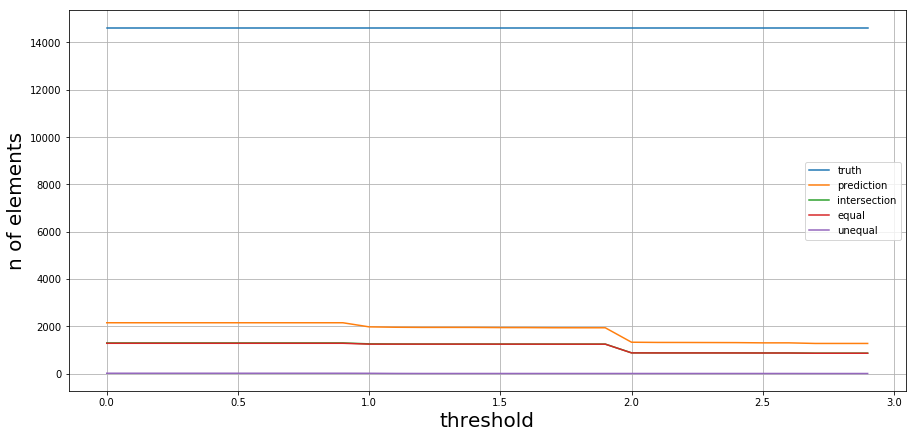

In [395]:

plt.figure(figsize=(15,7))

plt.plot(stat_list[:,-1],stat_list[:,6])
plt.plot(stat_list[:,-1],stat_list[:,5])
plt.plot(stat_list[:,-1],stat_list[:,4])
plt.plot(stat_list[:,-1],stat_list[:,7])
plt.plot(stat_list[:,-1],stat_list[:,8])

plt.grid()
plt.xlabel('threshold', fontsize=20)
plt.ylabel('n of elements', fontsize=20)
plt.legend(['truth','prediction', 'intersection','equal','unequal'])
plt.show()

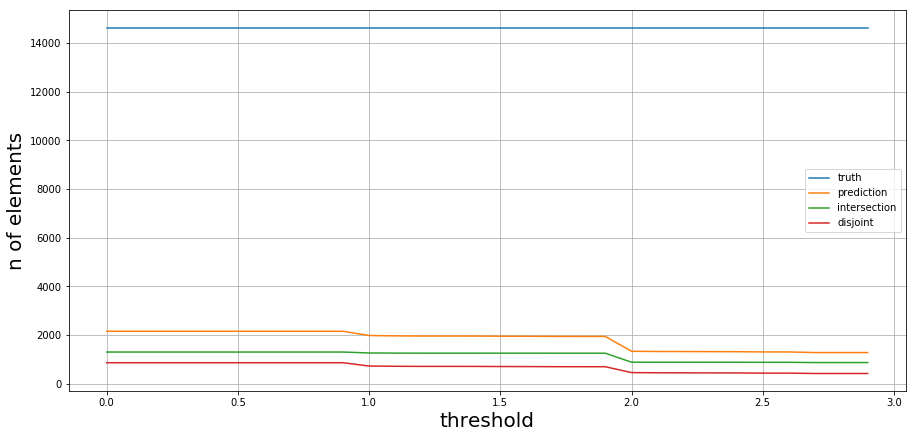

In [397]:

plt.figure(figsize=(15,7))

plt.plot(stat_list[:,-1],stat_list[:,6])
plt.plot(stat_list[:,-1],stat_list[:,5])
plt.plot(stat_list[:,-1],stat_list[:,4])
plt.plot(stat_list[:,-1],stat_list[:,9])

plt.grid()
plt.xlabel('threshold', fontsize=20)
plt.ylabel('n of elements', fontsize=20)
plt.legend(['truth','prediction', 'intersection','disjoint'])
plt.show()

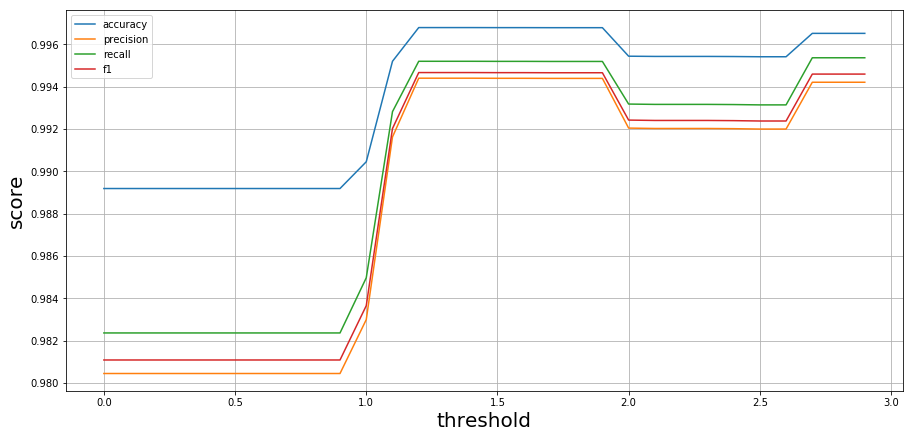

In [396]:
plt.figure(figsize=(15,7))
plt.plot(stat_list[:,-1],stat_list[:,0])
plt.plot(stat_list[:,-1],stat_list[:,1])
plt.plot(stat_list[:,-1],stat_list[:,2])
plt.plot(stat_list[:,-1],stat_list[:,3])
plt.grid()
plt.xlabel('threshold', fontsize=20)
plt.ylabel('score', fontsize=20)
plt.legend(['accuracy', 'precision','recall','f1'])
plt.show()

In [406]:
predicted = pd.DataFrame(matches)
predicted = predicted[predicted['score'].astype(float) >= 3.0]
true = pd.DataFrame(true_matches)

predicted = predicted[~predicted['doremus_uri'].isin(true['doremus_uri'])].sort_values(by='score').values.tolist()
print(len(predicted))
for uri in predicted:
        pprint(uri)

413
['http://data.doremus.org/artist/009540ee-244b-3332-9c2f-2d6e09603677',
 '3.0',
 'http://www.wikidata.org/entity/Q5547245']
['http://data.doremus.org/artist/a27fc786-1c36-3a70-8e04-649237ed05b6',
 '3.0',
 'http://www.wikidata.org/entity/Q1231115']
['http://data.doremus.org/artist/a27b1b3b-d37d-3f04-a3a2-a62cccfca190',
 '3.0',
 'http://www.wikidata.org/entity/Q1687860']
['http://data.doremus.org/artist/a0d750ec-1d52-378a-8864-c1e499fa8667',
 '3.0',
 'http://www.wikidata.org/entity/Q966778']
['http://data.doremus.org/artist/a0c496af-0c8d-30ed-9858-3e495b4923ad',
 '3.0',
 'http://www.wikidata.org/entity/Q710733']
['http://data.doremus.org/artist/a06fb3a5-2ee7-39fd-93c8-d3cc757cde77',
 '3.0',
 'http://www.wikidata.org/entity/Q46096']
['http://data.doremus.org/artist/9dd438f3-fdc9-355b-893e-e7bb9ab147d9',
 '3.0',
 'http://www.wikidata.org/entity/Q1290316']
['http://data.doremus.org/artist/9dbaadc5-e795-3306-982c-8b2bd5187340',
 '3.0',
 'http://www.wikidata.org/entity/Q48173']
['http://d

Here we can find one more negative match, http://data.doremus.org/artist/9f31efcb-014c-36ee-bea8-ad5fe3953097 , and in this case we are wrong. This means that after the threshold of 3.8 we start having some problems.  